## imports and reading data

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore, median_abs_deviation
import numpy as np

/tmp/ipykernel_13115/975891219.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
item_categories = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv('../data/items.csv')
sales = pd.read_csv('../data/sales_train.csv')
shops = pd.read_csv('../data/shops.csv')
test = pd.read_csv('../data/test.csv')

## looking at tables' shapes and columns

In [ ]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
print(shops.shape)
shops.head()
# weird values in the beginning (eps. considering the fact that they're doubled in a normal format)


(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## checking data for errors

#### looking for values that don't make sense and  `NaN`s

In [ ]:
template = 'Column {:15} -> {:4} nans'
for col in sales.columns:
    print(template.format(col, sales[col].isna().sum()))

Column date            ->    0 nans
Column date_block_num  ->    0 nans
Column shop_id         ->    0 nans
Column item_id         ->    0 nans
Column item_price      ->    0 nans
Column item_cnt_day    ->    0 nans


In [ ]:
# see if there're any items with negative price

sales[sales['item_price']<=0].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,15.05.2013,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19


found no `NaN`s, but found an item with negative price, which has to be removed later

#### Looking for unresolved relations between tables

we get no empty values after left joining different tables together, which means there are no references to unexisting values.

In [31]:
# check if some sales reference a shop that is not listed in shops 

#using left join so we necessarily include all the sales
# check on shops and items that are present in test, but not listed in train
tmp = pd.DataFrame()
tmp['is_present'] = sales['shop_id'].isin(shops['shop_id'])
tmp[tmp['is_present'] == False].shape

(0, 1)

In [32]:
# check if some sales reference an item that is not listed in items

tmp = pd.DataFrame()
tmp['is_present'] = sales['item_id'].isin(items['item_id'])
tmp[tmp['is_present'] == False].shape

(0, 1)

In [33]:
# check on shops and items that are present in test, but not listed in train
tmp = pd.DataFrame()
tmp['is_present'] = test['item_id'].isin(sales['item_id'])
tmp[tmp['is_present'] == False].shape

(15246, 1)

In [34]:
# check on shops and shops that are present in test, but not listed in train
tmp = pd.DataFrame()
tmp['is_present'] = test['shop_id'].isin(sales['shop_id'])
tmp[tmp['is_present'] == False].shape

(0, 1)

some of the items in `test` are not present in the train set, which mean that predictions for them are going to be made based off the item category

In [13]:
# items with unknown category

items[items.merge(item_categories, on='item_category_id', how='left')['item_category_name'].isna()]

,item_name,item_id,item_category_id


#### looking for noisy text values

there are several entries in `shops` and `items` that contain inappropriate symbols. for example there's `!Якутск Орджоникидзе, 56 фран` in `shops` and `***В ЛУЧАХ СЛАВЫ (UNV) D` in `items`. they contain exclamation marks and/or asterisks in the beginning. we can then attemtp to find similar values using the following alagorithm:
1. use a regex to detect and remove inappropriate characters
2. create a lookup-table that contains:
    - the value we just cleared, the one we want to replace
    - a value that is *now* identical to the cleared one, but has a different id
    - the id of a new value
3. use the lookup table to remap the id's of a noisy name to the id of a normal name
4. for some cases there are no suitable values to remap to, so we just clear the original name and leave the id as it is

In [ ]:
pattern = r"^[А-Яа-яA-Za-z][А-Яа-яA-Za-z0-9\s\"\.,\-\(\)]*$"
shops[~shops['shop_name'].str.match(pattern)]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [35]:
shops[shops['shop_name'].str.contains('Якутск Орджоникидзе')]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57


here we can see an example of so called noisy duplicate. the value `!Якутск Орджоникидзе, 56 фран` is basically a duplicate of `Якутск Орджоникидзе, 56` but with some additional characters.

In [15]:
#item names can include pretty much anything so I'm checking only the beginnning

pattern = r"^[А-Яа-яA-Za-zЁё0-9].*$"
items[~items['item_name'].str.match(pattern)]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


#### checking data types in tables

some values may have to be transfered to a different types, for example `date` should be of type `datetime` and `item_cnt_day` should be an integer since it represents the quantity of items sold

In [16]:
sales.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [17]:
# changing to datetime here so it can be processed faster while plotting
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

#### looking for shops with too few sales

the lowest value is 306, so it's probably okay

In [18]:
# no shops with too few sales, so that's good

sales['shop_id'].value_counts().sort_values().head()

shop_id
36     306
11     499
20    1792
8     3412
9     3751
Name: count, dtype: int64

## defining functions for plotting the data

In [41]:
def histplots(df : pd.DataFrame, column_names: list[str], bins : int = 200, title = None):
    plt.figure(figsize = (20, 5))
    if title: plt.suptitle(title)
    sns.set_palette(sns.color_palette('pastel'))
    for index, col in enumerate(column_names):
        plt.subplot(1, len(column_names), index+1)
        sns.histplot(df[col], bins=bins, log_scale=True if col != 'item_id' else False)
    plt.show()

In [39]:
def boxplots(df: pd.DataFrame, column_names: list[str], title=None):
    plt.figure(figsize=(20, 5))
    if title:
        plt.suptitle(title)
    sns.set_palette(sns.color_palette('pastel'))
    for index, col in enumerate(column_names):
        plt.subplot(1, len(column_names), index+1)
        sns.boxplot(df[col])
    plt.show()

## plotting the data

In [38]:
num_cols = ['item_id', 'item_price', 'item_cnt_day']

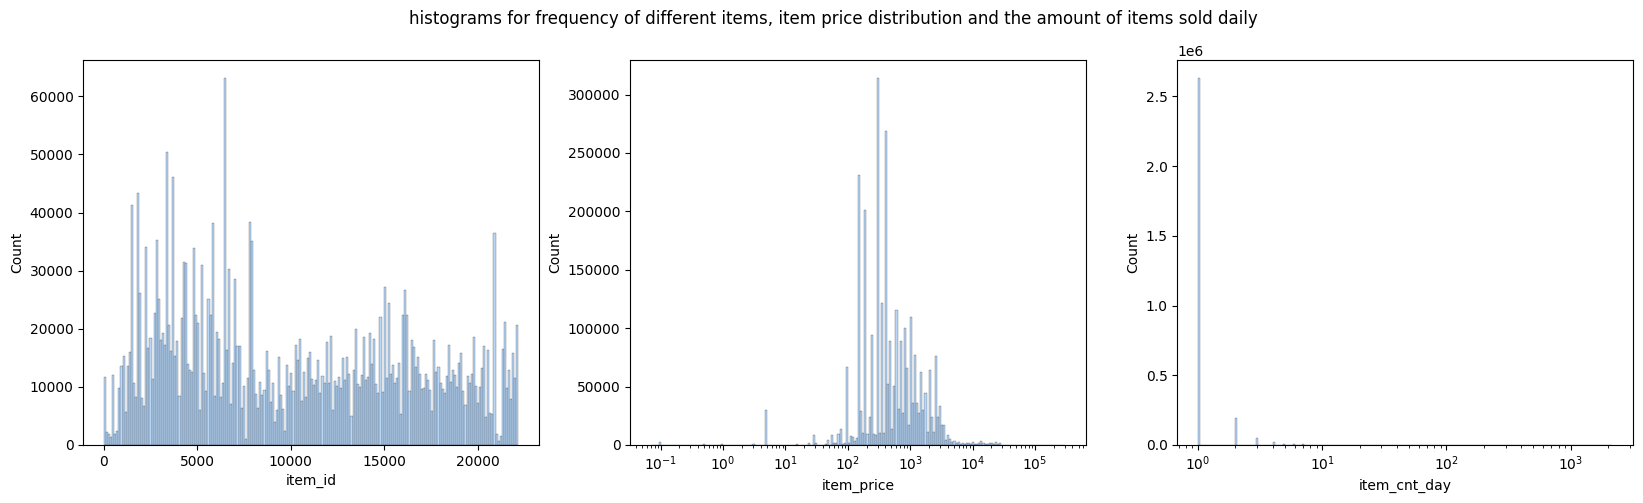

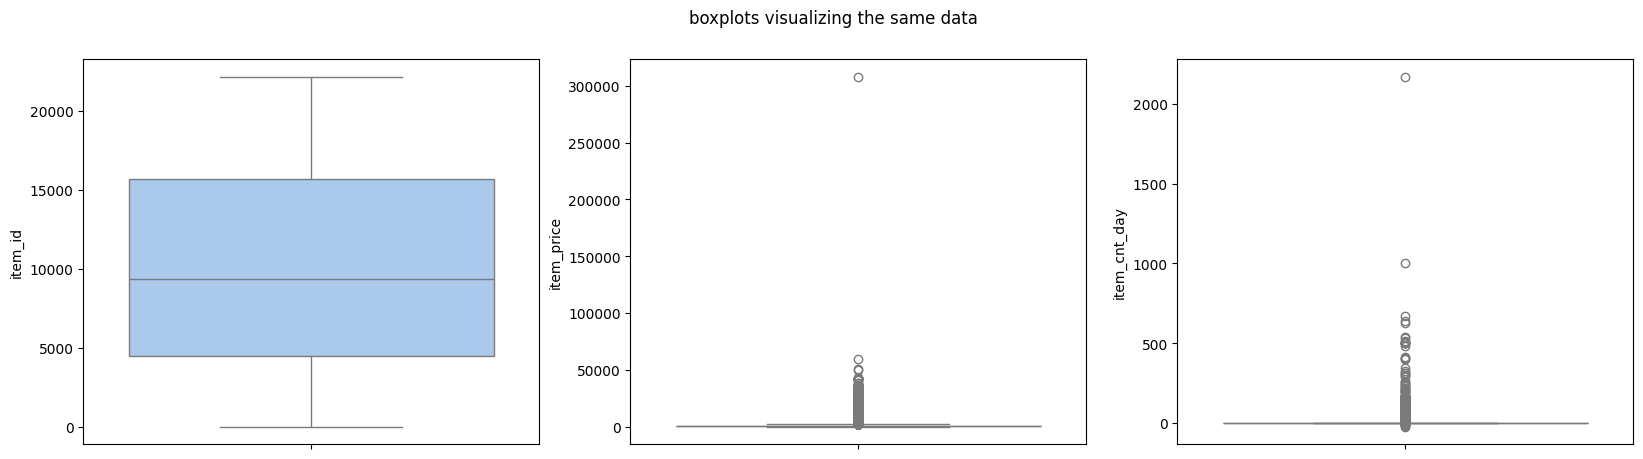

In [42]:
histplots(sales, num_cols, title="histograms for frequency of different items, item price distribution and the amount of items sold daily")
boxplots(sales, num_cols, title="boxplots visualizing the same data")

can see some distanced outliers in `item_price` and `item_cnt_day`, which have to be cleared later

#### checking for atypical spikes in sales

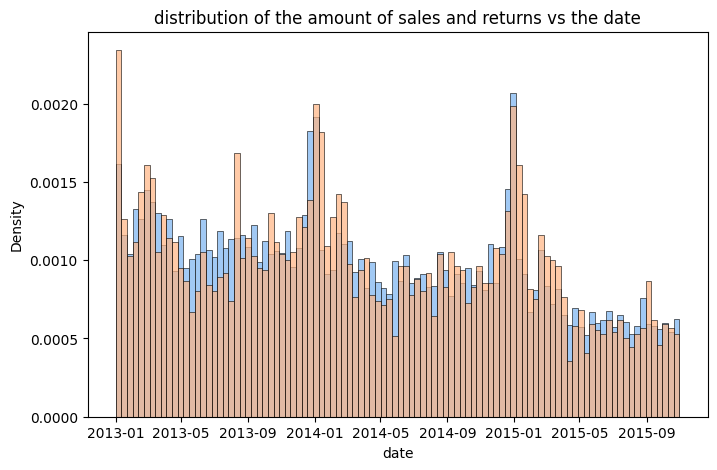

In [23]:
#using density as stat here so histograms have the same scale

plt.figure(figsize=(8, 5))
plt.title("distribution of the amount of sales and returns vs the date")
sns.histplot(sales['date'], bins=100, stat='density', alpha = 1)
sns.histplot(sales[sales['item_cnt_day'] < 0]['date'],
             bins=100, stat='density', alpha = 0.7)
plt.show()

both sales and returns spike around new year, which makes sense, so won't consider those spikes atypical

## checking which items form the outliers

In [24]:
mask = sales['item_cnt_day'] > 500
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2014-04-22,15,27,8057,1200.000000,502.0,iTunes 1500 руб.,32
1,2014-06-28,17,25,20949,5.000000,501.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2,2014-10-02,21,12,9242,1500.000000,512.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8
3,2014-10-09,21,55,19437,899.000000,508.0,"Средиземье: Тени Мордора [PC, Цифровая версия]",31
4,2015-01-15,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
5,2015-04-14,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30
6,2015-05-19,28,12,11373,155.192950,539.0,Доставка до пункта выдачи (Boxberry),9
7,2015-09-29,32,55,9249,1500.000000,533.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
8,2015-09-30,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
9,2015-09-30,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80


the table above made me wanna check different types of tickets, because they look very similar. perhaps, they can be join into a single item type

In [25]:
with pd.option_context('display.max_colwidth', 400):
    display(items[items['item_name'].str.contains("Билет")])

,item_name,item_id,item_category_id
9240,"Билет ""День Бухгалтерии""",9240,73
9241,"Билет ""ИгроМир 2014"" (на один день (отдельно - 3 октября 2014))",9241,8
9242,"Билет ""ИгроМир 2014"" (на один день (отдельно - 4, 5 октября 2014))",9242,8
9243,"Билет ""ИгроМир 2014"" - семейный до 4-х человек вкл. (на один день (отдельно - 3, 4, 5 октября 2014))",9243,8
9244,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [Цифровая версия]",9244,80
9245,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) УПР [Цифровая версия]",9245,8
9246,"Билет ""ИгроМир 2015"" - 2 октября 2015 [Цифровая версия]",9246,80
9247,"Билет ""ИгроМир 2015"" - 2 октября 2015 УПР [Цифровая версия]",9247,8
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [Цифровая версия]",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) УПР [Цифровая версия]",9249,8


In [47]:
mask = sales['item_price'] > 35000
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,11.09.2013,8,12,2410,36990.0,1.0,CorelDRAW Graphics Suite X6 - Small Business E...,75
1,17.09.2013,8,12,11365,59200.0,1.0,Доставка (EMS),9
2,24.10.2013,9,12,7238,42000.0,1.0,UserGate Proxy & Firewall 6.X до 100 сессий,75
3,19.11.2013,10,12,5748,35990.0,1.0,Photoshop 13 Windows Russian BOX,75
4,13.12.2013,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
5,10.02.2014,13,12,5748,36990.0,1.0,Photoshop 13 Windows Russian BOX,75
6,20.03.2014,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69
7,16.04.2014,15,14,5748,36990.0,1.0,Photoshop 13 Windows Russian BOX,75
8,09.05.2014,16,5,5748,36990.0,1.0,Photoshop 13 Windows Russian BOX,75
9,20.11.2014,22,12,14173,40900.0,1.0,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,75


In [52]:
mask = sales['item_price'] < 1
sales[mask].merge(items, on='item_id', how='inner')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,15.05.2013,4,32,2973,-1.000000,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19
1,16.06.2013,5,30,11859,0.100000,1.0,Змей ВАСЯ с цветком 33 см,63
2,13.06.2013,5,30,11855,0.100000,1.0,Змей ВАСЯ 33 см,63
3,06.06.2013,5,30,11858,0.100000,1.0,Змей ВАСЯ с цветком 22 см,63
4,09.06.2013,5,30,11858,0.100000,1.0,Змей ВАСЯ с цветком 22 см,63
...,...,...,...,...,...,...,...,...
4653,02.10.2015,33,58,15334,0.990000,1.0,Мягкая игрушка Барашек Бумбарашек 23см,63
4654,11.10.2015,33,58,15334,0.990000,1.0,Мягкая игрушка Барашек Бумбарашек 23см,63
4655,01.10.2015,33,58,15344,0.990000,2.0,Мягкая игрушка Веселая овечка 27см,63
4656,28.10.2015,33,12,11373,0.908714,2169.0,Доставка до пункта выдачи (Boxberry),9


apart from a negative price mentioned before, we can see some really atypical prices from items. this might be a system error, but it occurs quite often so it's probably some kind of a special offer, which means they should probably stay in the data

checking items with most overall sales

In [53]:
items.merge(sales['item_id'].value_counts(), on='item_id', how='inner').sort_values('count', ascending=False).head(15)

,item_name,item_id,item_category_id,count
20602,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,31340
5717,Playstation Store пополнение бумажника: Карта ...,5822,35,9408
17418,Прием денежных средств для 1С-Онлайн,17717,79,9067
2749,"Diablo III [PC, Jewel, русская версия]",2808,30,7479
4097,Kaspersky Internet Security Multi-Device Russi...,4181,75,6853
7698,World of Warcraft. Карта оплаты игрового време...,7856,28,6602
3654,"Grand Theft Auto V [PS3, русские субтитры]",3732,19,6475
2263,"Call of Duty: Black Ops II [PС, Jewel, русская...",2308,30,6320
4782,"Minecraft [Xbox 360, английская версия]",4870,23,5811
3656,"Grand Theft Auto V [Xbox 360, русские субтитры]",3734,23,5805


## conclusion 


- Data does not contain unresolved references
- There are some outliers in data, which will have to be cleared 
- Different tables do not conflict with each other, however, in `items` and `shops` there are some duplicate values, references to which will have to be resolved later
- There's one item sold with negative price, so it should be removed
- Different kinds of tickets to the same event should *maybe* be merged into one
